## ACGPN

- Original: https://github.com/levindabhi/ACGPN.git
- Modified: https://github.com/kairess/ACGPN.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!git clone https://github.com/kairess/ACGPN.git
%cd ACGPN

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 21.65 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/ACGPN


## Dependencies

In [2]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     |████████████████████████████████| 145 kB 31.7 MB/s 


In [3]:
import gdown
import numpy as np
from PIL import Image
import IPython
import gdown
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [4]:
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [5]:
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
!git clone https://github.com/levindabhi/U-2-Net.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 769 (delta 71), reused 62 (delta 62), pack-reused 670
Receiving objects: 100% (769/769), 3.80 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Total 822 (delta 0), reused 0 (delta 0), pack-reused 822
Receiving objects: 100% (822/822), 30.72 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (379/379), done.


## 사전학습 모델 다운로드

### 포즈 예측 모델

In [6]:
!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel

Downloading...
From: https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:01<00:00, 141MB/s]


### 휴먼 세그멘테이션 마스크 생성 모델

In [7]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:02<00:00, 116MB/s] 


'lip_final.pth'

### U2Net 모델

옷 마스크 추출 모델

In [8]:
%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd ..

/content/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 201MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:03<00:00, 56.8MB/s]
...load U2NEP---4.7 MB
/content/ACGPN


### ACGPN 모델

In [9]:
!mkdir checkpoints

gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From: https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:06<00:00, 78.2MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


## 전처리

### 옷 마스크 추출

In [11]:
sorted(os.listdir('inputs/cloth'))[0]

'000812_1.jpg'

In [13]:
jpg1 = os.listdir('/content/ACGPN/inputs/cloth')

In [19]:
os.chdir('/content/ACGPN')

Generating mask for: cloth_1671271699.png
Saving output at Data_preprocessing/test_edge/cloth_1671271699.png


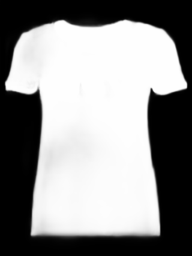

In [10]:
cloth_name = f'cloth_{int(time.time())}.png'

cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth'))[0])
cloth = Image.open('/content/ACGPN/inputs/cloth/000812_1.jpg')
cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

Image.open(f'Data_preprocessing/test_edge/{cloth_name}')

### 모델 포즈, 세그멘테이션

In [26]:
sorted(os.listdir('inputs/img'))

['000501_0.jpg',
 '000514_0.jpg',
 '000523_0.jpg',
 '000532_0.jpg',
 '스크린샷_20221217_042918.png']

In [11]:
img_name = f'img_{int(time.time())}.png'

img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])
img = Image.open('/content/ACGPN/inputs/img/스크린샷_20221217_065822.png')
img = img.resize((192,256), Image.BICUBIC)

img_path = os.path.join('Data_preprocessing/test_img', img_name)
img.save(img_path)

!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))
generate_pose_keypoints(img_path, pose_path)

100% 1/1 [00:01<00:00,  1.71s/it]
File saved at Data_preprocessing/test_pose/img_1671271729_keypoints.json


## 추론

In [12]:
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
    f.write(f'{img_name} {cloth_name}')

In [13]:
%cd /content/ACGPN

/content/ACGPN


In [14]:
!python test.py

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

## 결과

In [ ]:
output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/{img_name}'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid

In [43]:
import numpy as np

a = np.array(Image.open(f'Data_preprocessing/test_img/{img_name}'))
np.delete(a,-1)
b = np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}'))
c = np.array(Image.open(f'results/test/try-on/{img_name}'))
# output_grid = np.concatenate((a, b,c))
# image_grid = Image.fromarray(output_grid)
# image_grid

FileNotFoundError: ignored

In [37]:
a

array([[[195, 197, 186, 255],
        [157, 159, 148, 255],
        [163, 164, 156, 255],
        ...,
        [161, 162, 156, 255],
        [161, 162, 156, 255],
        [162, 163, 157, 255]],

       [[189, 191, 179, 255],
        [151, 153, 143, 255],
        [156, 157, 149, 255],
        ...,
        [162, 163, 157, 255],
        [161, 162, 156, 255],
        [161, 162, 156, 255]],

       [[181, 183, 171, 255],
        [145, 147, 136, 255],
        [146, 147, 138, 255],
        ...,
        [162, 163, 156, 255],
        [161, 162, 156, 255],
        [161, 162, 155, 255]],

       ...,

       [[108, 108, 104, 255],
        [119, 119, 117, 255],
        [151, 152, 147, 255],
        ...,
        [158, 160, 155, 255],
        [158, 160, 155, 255],
        [157, 160, 154, 255]],

       [[108, 108, 105, 255],
        [119, 119, 117, 255],
        [150, 151, 146, 255],
        ...,
        [157, 159, 154, 255],
        [156, 159, 154, 255],
        [156, 159, 154, 255]],

       [[108

In [38]:
b

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [41]:
np.delete(c,0)

array([242, 243, 247, ..., 237, 234, 233], dtype=uint8)

In [ ]:
output_grid = np.concatenate((a, b,c))
image_grid = Image.fromarray(output_grid)
image_grid